# 앙상블 모형 기반 신용카드 일별 매출 예측
 - Key Questions
 - What I focused on this project

## Summary
- **앙상블 모형은 일별 매출을 비교적 정확하게 예측한다.**  
  (월 매출 오차 약 460억, 전체 매출 대비 1.8%, 2024.06 예측 기준)
- **LightGBM** 모델이 가장 우수한 성능을 보였고  
  **XGBoost**와 **RandomForest** 모델도 비교적 높은 예측 정확도를 기록했다.
- 매출 예측에 **연도**, **월**, **요일** 등이 중요한 영향을 미친다.


## 1. 프로젝트 개요

이 프로젝트는 신용카드 일별 매출 데이터를 기반으로 미래 매출을 예측하고자 한다. 미래 매출 예측은 마케팅 캠페인 기획, 재무 계획 설립 등 다양한 사업 영역에서 활용한다. 

실제 업무 환경에서도 체계적인 매출 예측방법론이 존재하지 않고 담당자의 경험과 재량에 의존하는 경우도 많다. 체계적인 예측방법론 정립을 위해 **RandomForest**, **XGBoost**, **LightGBM** 3가지 머신러닝 모델을 사용하여 예측 성능을 비교하였다.

In [34]:
# %% 0. Environment Settings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rc('font', family='Malgun Gothic')  # Windows
# plt.rc('font', family='AppleGothic')  # Mac
plt.rc('axes', unicode_minus=False)

## 2. 데이터 로딩

### 데이터 출처
데이터는 **KDX 한국데이터거래소**에서 제공하는 **NH농협카드 일자별 소비현황_서울** 데이터셋을 사용한다. 데이터는 월별로 제공되며, 각 파일은 'YYYYMM' 형식으로 저장된다. 데이터 오너십을 가지고 있지 않아 리포지토리에는 제외하지만 아래 공개 데이터 링크에서 직접 다운받을 수 있다.

- **데이터명**: [NH농협카드] 일자별 소비현황_서울
- **URL**: [KDX 데이터 상세](https://kdx.kr/data/product-list?specs_id=MA38230007&corp_id=CORP000024&category_id=CA000004)

### 데이터 확인
- 훈련 데이터: 2020.01 ~ 2023.12
- 검증 데이터: 2024.01 ~ 2024.06
- 주요 컬럼은 카드 사용 금액과 건수, 승인 일자 등의 정보를 포함한다.

In [35]:
# %% 1. LOAD THE DATA
# Data Source: KDX Data - [NH농협카드] 일자별 소비현황_서울
bas_ym = pd.date_range(start='20200101', end='20240630', freq='MS').strftime('%Y%m').tolist()

df = pd.DataFrame()

for i, var in enumerate(bas_ym):
    data_path = f'data/[NH농협카드] 일자별 소비현황_서울_{var}.csv'
    
    # Read the data with available encodings
    encodings = ['utf-8-sig', 'euc-kr', 'cp949']
    for encoding in encodings:
        try:
            tmp_df = pd.read_csv(data_path, encoding=encoding)
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError(f"Failed to read {data_path} with available encodings.")
    
    df = pd.concat([df, tmp_df], axis=0)
    
print(df.shape)
print(df.head())

(1643, 8)
   시도      승인일자  이용건수_전체  이용금액_전체  이용건수_개인  이용금액_개인  이용건수_법인  이용금액_법인
0  서울  20200101   1827.0  48116.0   1770.0  45654.0     57.0   2462.0
1  서울  20200102   2071.0  78042.0   1932.0  66654.0    139.0  11388.0
2  서울  20200103   2140.0  77224.0   1995.0  64302.0    144.0  12922.0
3  서울  20200104   1969.0  55070.0   1891.0  51702.0     78.0   3369.0
4  서울  20200105   1711.0  46359.0   1649.0  43796.0     62.0   2563.0


## 3. 데이터 전처리

### 3.1. 데이터 타입 변환
- 승인일자를 `datetime64` 타입으로 변환하고 금액 변수들의 단위를 분석에 용이하게 변경한다.

### 3.2. 파생 변수 생성
- 연도(`year`), 월(`month`), 일(`day`), 요일(`dayofweek`), 주말 여부(`weekend`) 등의 파생 변수를 생성하여 모델에 활용할 수 있도록 한다.
- 금액의 평균을 나타내는 변수들도 분석 참고용으로 생성한다 (`avg_sales`, `avg_sales_psn`, `avg_sales_cor`).

In [36]:
# %% 2. DATA PREPROCESSING
# Type Conversion (int64 -> datetime64)
df['date'] = pd.to_datetime(df['승인일자'], format='%Y%m%d')

# Decimal Point Handling
df['이용금액_전체_억원'] = df['이용금액_전체'] / 100
df['이용금액_개인_억원'] = df['이용금액_개인'] / 100
df['이용금액_법인_억원'] = df['이용금액_법인'] / 100

# Derived Variables
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

# Nominal to Ordinal Variable
df['dayname'] = pd.Categorical(df['date'].dt.day_name(), 
                               categories=['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'],
                               ordered=True)

# Add weekend variable
df['weekend'] = df['dayname'].isin(['Saturday', 'Sunday'])

# Nullity Check
print(df.isna().sum())

# Train-Test Split
df_train = df[df['year'] != 2024]
df_test = df[df['year'] == 2024]

print(df_train.shape, df_test.shape)

# Reset Index
df.reset_index(drop=True, inplace=True)

시도            0
승인일자          0
이용건수_전체       0
이용금액_전체       0
이용건수_개인       0
이용금액_개인       0
이용건수_법인       0
이용금액_법인       0
date          0
이용금액_전체_억원    0
이용금액_개인_억원    0
이용금액_법인_억원    0
year          0
month         0
day           0
dayofweek     0
dayname       0
weekend       0
dtype: int64
(1461, 18) (182, 18)


## 4. 데이터 탐색적 분석 (EDA)

### 4.1. 결측치 확인
- 데이터에서 결측치를 시각적으로 확인하고 적절히 처리한다.
- `sns.heatmap`을 사용하면 결측치를 시각화할 수 있지만 대규모 데이터의 경우 시각적으로 확인하기 힘드므로 `.sum` 등으로도 확인한다.


### 4.2. 변수 간 상관관계 확인

- 상관 행렬을 통해 변수들 간의 상관관계를 확인하고, 다중공선성 문제를 방지하기 위해 일부 변수를 제거하거나 변형할 수 있다.
- 본 분석에서는 주요 독립변수인 연도(`year`), 월(`month`), 일(`day`), 요일(`dayofweek`) 간 상관성이 낮아 변수 제거는 시행하지 않았다. 


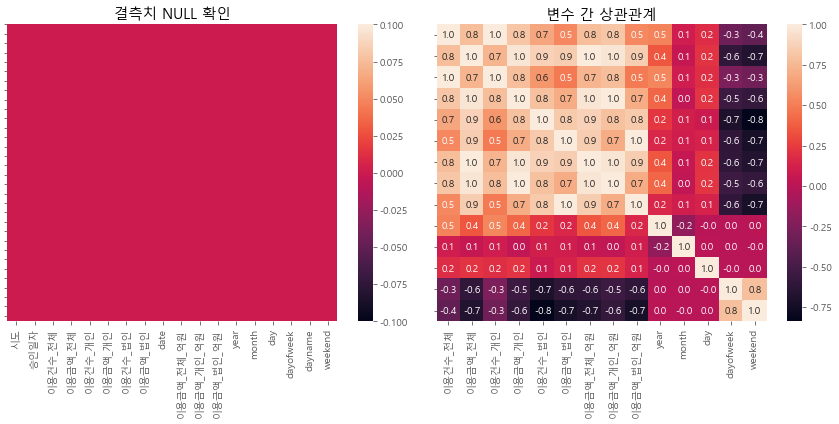

In [37]:
# %% 3. EDA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# 3-1. Null Handling
sns.heatmap(df.isna(), ax=axes[0])
axes[0].set_title('결측치 NULL 확인')
axes[0].set_yticklabels([])

# 3-2. Correlation Matrix (Multicolinearity Check)
corr_mat = df.drop(['시도', '승인일자', 'dayname'], axis=1).corr()

sns.heatmap(corr_mat, annot=True, fmt='.1f', ax=axes[1])
axes[1].set_yticklabels([])

axes[1].set_title('변수 간 상관관계')
plt.tight_layout()
plt.show()

### 4.3. 이상치 탐지/제거

주요 변수들에 대해 선형 그래프와 박스플롯을 사용하여 이상치를 탐지한다.

- 일반적으로는 IQR, 2표준편차 방식을 사용해서 이상치를 탐지하고 제외한다.
- **IQR을 벗어난다고 무작정 제외하지 않는다.** 예를 들어 법인 매출에는 유독 튀는 몇몇 날짜가 존재한다. 데이터 오류(이상치)일 수도 있지만 실제 주요 실적일 수 있다. 
- 법인 거래는 거래빈도는 작고 거래금액은 크다. 기계적으로 이상치로 판단해 해당 값을 제외할 경우 실적을 과소추정할 수 있다.
- raw data에 접근 가능한 상황이라면 가장 먼저 데이터를 의심하고 raw date를 확인한다. 만약 문제가 없거나 접근이 불가능한 상태라면 각 업무 담당자에게 확인하는 것이 좋다.

이러한 문제로 본 분석에서는 이상치 제거를 수행하지 않고 이후 분석을 진행한다.

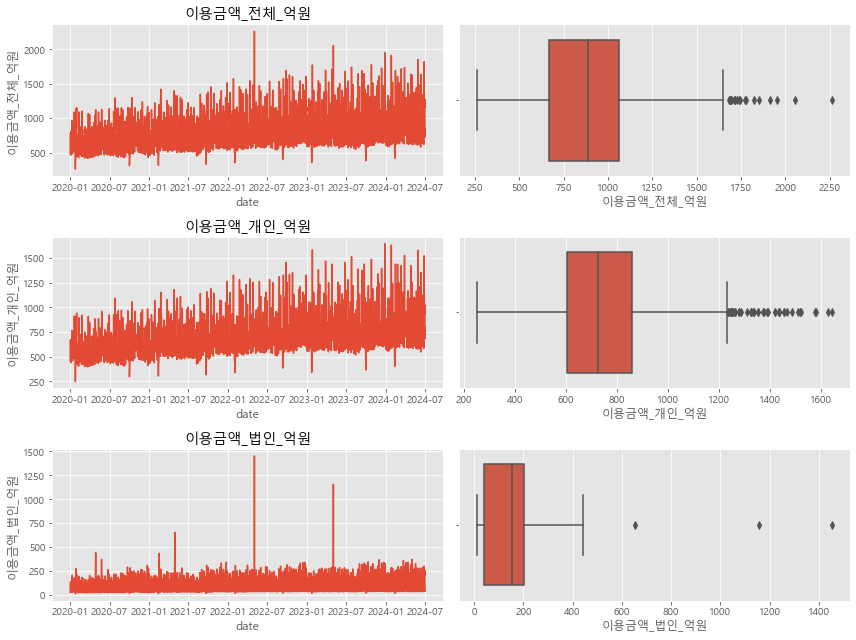

In [38]:
# 3-3. Outlier Detection
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9))

variables = ['이용금액_전체_억원', '이용금액_개인_억원', '이용금액_법인_억원']
 
for i, vars in enumerate(variables):
    sns.lineplot(data=df, x='date', y=vars,
                ax=axes[i%3][0])
    sns.boxplot(data=df, x=vars,
                ax=axes[i%3][1])
    axes[i%3][0].set_title(vars)

    plt.tight_layout()

fig.suptitle('')
plt.show()

### 4.4. 매출 분석

- 매출 데이터는 요일별, 월별로 시각화하여 소비 패턴을 분석한다. 이를 통해 매출이 특정 요일이나 월에 따라 차이를 보인다는 인사이트를 도출한다.

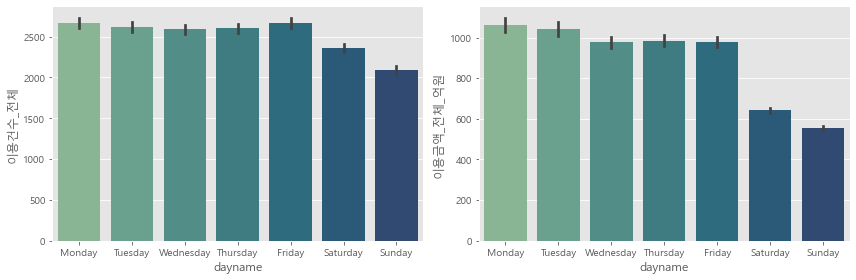

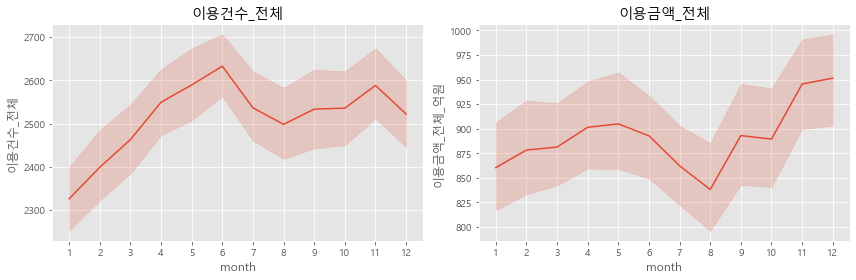

In [39]:
# 3-4. Sales by Day
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.barplot(data=df, x='dayname', y='이용건수_전체', 
            palette='crest', ax=axes[0])
sns.barplot(data=df, x='dayname', y='이용금액_전체_억원', 
            palette='crest', ax=axes[1])
plt.tight_layout()
plt.show()

# 3-5. Sales by Month
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.lineplot(data=df, x='month', y='이용건수_전체',
            palette='crest', ax=axes[0])
sns.lineplot(data=df, x='month', y='이용금액_전체_억원',
            palette='crest', ax=axes[1])

axes[0].set_title('이용건수_전체')
axes[1].set_title('이용금액_전체')
axes[0].set_xticks(range(1,13))
axes[1].set_xticks(range(1,13))

plt.tight_layout()
plt.show()

## 5. 모델링

### 5.1. 회귀 모델 설정

- 모델링을 위해 **RandomForest**, **XGBoost**, **LightGBM**을 사용하여 예측을 수행한다. 
- 각 모델은 카드 사용 금액(‘이용금액_개인_억원’)을 종속 변수로 설정하고, 연도, 월, 요일 등의 변수를 독립 변수로 설정하여 학습한다.


In [40]:
from sklearn.model_selection import train_test_split

# 4-1. Train-Validation Split
ind_vars = ['승인일자', 'year', 'month', 'day', 'dayofweek']
dep_vars = ['이용건수_개인', '이용건수_법인', '이용금액_개인_억원', '이용금액_법인_억원']

X = df[df['year'] != 2024][ind_vars]
y = df[df['year'] != 2024][dep_vars]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2, 
                                                      random_state=42
                                                      )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1168, 5) (1168, 4)
(293, 5) (293, 4)


### 5.2. 모델 학습
- **RandomForestRegressor**는 1000개의 트리와 최대 깊이 20으로 설정하고,
- **XGBRegressor**와 **LGBMRegressor**는 기본 하이퍼파라미터를 사용하여 학습한다.


In [41]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 4-2. Machine Learning (RandomForest, XGBoost, LightGBM)
dep_var = '이용금액_개인_억원'

model_rf = RandomForestRegressor(n_estimators=1000,
                                 max_depth=20,
                                 random_state=42)
model_xgb = XGBRegressor(random_state=42)
model_lgbm = LGBMRegressor(random_state=42)

model_rf.fit(X_train, y_train[dep_var])
model_xgb.fit(X_train, y_train[dep_var]) 
model_lgbm.fit(X_train, y_train[dep_var])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 5
[LightGBM] [Info] Start training from score 738.366739


LGBMRegressor(random_state=42)

### 5.3. 모델 성능 평가

- **MSE (Mean Squared Error)**를 사용하여 각 모델의 성능을 비교하였다.  
- RandomForest는 (n_estimators=1000, max_depth=20)로, XGBoost와 LightGBM은 디폴트 설정으로 모델을 학습시켰다.
- 결과적으로 LightGBM이 가장 높은 정확도를, RF 모형이 가장 낮은 정확도를 보였다.

#### **모델별 MSE 결과**
| 모델           | MSE          |
|----------------|--------------|
| RandomForest   | 13,813.88    |
| XGBoost        | 11,969.03    |
| LightGBM       | 9,832.48     |

In [42]:
# 4-3. Model Comparison
from sklearn.metrics import mean_squared_error

y_valid_dep_var = y_valid[dep_var]

# Prediction
y_pred_rf = model_rf.predict(X_valid)
y_pred_xgb = model_xgb.predict(X_valid)
y_pred_lgbm = model_lgbm.predict(X_valid)

# MSE
mse_rf = mean_squared_error(y_pred_rf, y_valid_dep_var)
mse_xgb = mean_squared_error(y_pred_xgb, y_valid_dep_var)
mse_lgbm = mean_squared_error(y_pred_lgbm, y_valid_dep_var)

print(f'MSE (RandomForest): {mse_rf:.2f}')
print(f'MSE (XGBoost): {mse_xgb:.2f}')
print(f'MSE (LightGBM): {mse_lgbm:.2f}')

best_model = model_lgbm

MSE (RandomForest): 13813.88
MSE (XGBoost): 11969.03
MSE (LightGBM): 9832.48


## 6. 결과

### 6.1. 타겟 기간 예측 (2024년 6월)

2024년 6월 매출 데이터를 타겟으로 설정하고, 2024년 이전의 데이터를 학습에 사용하여 **RandomForest**, **XGBoost**, **LightGBM** 모델로 예측을 진행하였다. 각 모델의 성능은 **MSE (Mean Squared Error)**, **MAE (Mean Absolute Error)**, **MAPE (Mean Absolute Percentage Error)**를 기준으로 평가하였으며, 결과는 다음과 같다.

| 모델           | MSE          | MAE          | MAPE      |
|----------------|--------------|--------------|-----------|
| RandomForest   | 8,918.30     | 66.17        | 0.07      |
| XGBoost        | 4,714.77     | 50.93        | 0.06      |
| LightGBM       | 7,548.75     | 56.86        | 0.06      |


- **XGBoost**는 가장 낮은 MSE(4,714.77), MAE(50.93), MAPE(0.06)를 기록하며 검증 데이터 때와는 달리 가장 우수한 성능을 보였다.  
- **LightGBM**은 MAE와 MAPE에서 XGBoost와 비슷한 성능을 보였으나, MSE에서 약간 높은 값을 보여 중간 수준의 모델로 평가된다.  
- **RandomForest**는 모든 지표에서 가장 높은 값을 기록하며 상대적으로 낮은 성능을 보였다.  

**XGBoost**와 **LightGBM**은 실제 매출과의 근접한 예측을 제공하여 둘 다 신뢰할 수 있는 모델로 평가될 수 있다. 아래 코드에서는 MSE 결과만을 첨부한다.

In [45]:
# %% 5-1. Model Evaluation
test_period = df_test['date'].between('2024/06/01', '2024/06/30')

x_range = np.arange(1,len(df_test[test_period])+1)
X_test = df_test[test_period][ind_vars]
y_test = df_test[test_period][dep_var]

y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_lgbm = model_lgbm.predict(X_test)

mse_rf = mean_squared_error(y_pred_rf, y_test)
mse_xgb = mean_squared_error(y_pred_xgb, y_test)
mse_lgbm = mean_squared_error(y_pred_lgbm, y_test)

print(f'MSE (RandomForest): {mse_rf:.2f}')
print(f'MSE (XGBoost): {mse_xgb:.2f}')
print(f'MSE (LightGBM): {mse_lgbm:.2f}')

MSE (RandomForest): 8918.30
MSE (XGBoost): 4714.77
MSE (LightGBM): 7548.75


### 비즈니스 관점에서의 선택

| 모델            | 실제 매출액 (억 원) | 예측 매출액 (억 원) | 예측 오차 (억 원) | 예측 오차율 (%) |
|-----------------|--------------------|--------------------|------------------|----------------|
| **RandomForest** | 25,577.36          | 26,079.34          | 501.98           | 1.96          |
| **XGBoost**      | 25,577.36          | 24,786.21          | -791.15          | -3.09         |
| **LightGBM**     | 25,577.36          | 25,117.71          | -459.65          | -1.80         |


비즈니스 관점에서는 이해할 수 있는 지표가 중요할 때가 있다. 따라서 MSE, MAPE, MAE 대신 누적 예측오차를 구해 각 모형을 비교하였다. 누적 예측오차는 모형이 몇 억원을 과대/과소 추정했는지 한 번에 설명할 수 있는 지표다. 

$ 오차율 = \cfrac{(예측값 - 실제값)}{실제값} \times 100\% $

예측 오차율은 전체 매출 대비 누적 예측오차로 정의헀다. 현재 정의된 오차율에 따르면, **LightGBM**의 오차율(-1.80%)이 가장 낮다. 이를 바탕으로 오차는 전체 매출의 2% 미만이며, 꽤나 높은 정확도로 미래 매출을 예측할 수 있다고 주장(?)할 수 있다. 

물론 **XGBoost**의 MSE가 약 4714로 **LightGBM**보다 훨씬 낮은 것을 알고 있다. 그러나 이런 식의 설명이 필요할 때도 있다. 아래와 같이 쓸 수 있기 때문이다.

> "2023년 이전 데이터 기반으로 2024년 6월 매출을 오차 약 460억(전체 매출의 1.8%수준) 이내 예측"

In [72]:
print(f'''
RandomForest 예측 오차   : {y_pred_rf.sum() - y_test.sum():.2f} 억원
XGBoost 예측 오차        : {y_pred_xgb.sum() - y_test.sum():.2f} 억원
LightGBM 예측 오차       : {y_pred_lgbm.sum() - y_test.sum():.2f} 억원 
''')

print(f'''
실제 매출액              : {y_test.sum():.2f} 억원
RandomForest 예측 매출액 : {y_pred_rf.sum():.2f} 억원
XGBoost 예측 매출액      : {y_pred_xgb.sum():.2f} 억원
LightGBM 예측 매출액     : {y_pred_lgbm.sum():.2f} 억원
''')

print(f'''
RandomForest 예측 오차율 : {100*(y_pred_rf.sum() - y_test.sum())/y_test.sum():.2f} %
XGBoost 예측 오차율      : {100*(y_pred_xgb.sum() - y_test.sum())/y_test.sum():.2f} %
LightGBM 예측 오차율     : {100*(y_pred_lgbm.sum() - y_test.sum())/y_test.sum():.2f} %
''')


RandomForest 예측 오차   : 501.98 억원
XGBoost 예측 오차        : -791.15 억원
LightGBM 예측 오차       : -459.65 억원 


실제 매출액              : 25577.36 억원
RandomForest 예측 매출액 : 26079.34 억원
XGBoost 예측 매출액      : 24786.21 억원
LightGBM 예측 매출액     : 25117.71 억원


RandomForest 예측 오차율 : 1.96 %
XGBoost 예측 오차율      : -3.09 %
LightGBM 예측 오차율     : -1.80 %



### 6.2. 예측 시각화

2024년 6월 매출 데이터를 기준으로 **RandomForest**, **XGBoost**, **LightGBM** 모델의 예측 결과와 실제 매출 데이터를 시각화한 것이다.  

- **검정색 실선**은 실제 매출 데이터를 나타낸다.  
- **RandomForest**(빨간색 점선), **XGBoost**(파란색 점선), **LightGBM**(녹색 점선) 모두 매출을 상당히 정확하게 예측한다.

시각화만으로 정확히 파악은 어렵지만, **XGBoost**가 가장 일관되고 정확한 결과를 제공한다.

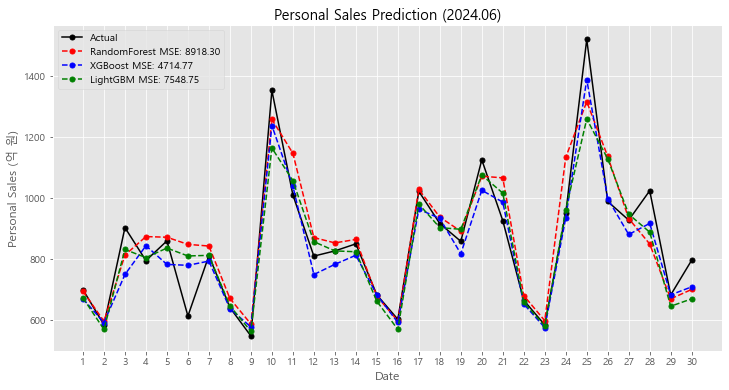

In [48]:
# %% 5-2. Model Visualization
plt.rc('figure', figsize=(12,6))

plt.plot(x_range, y_test, 
         marker='o', markersize=5, label='Actual', color='black')
plt.plot(x_range, y_pred_rf, 
         marker='o', markersize=5, label=f'RandomForest MSE: {mean_squared_error(y_pred_rf, y_test):.2f}', 
         linestyle='--', color='red')
plt.plot(x_range, y_pred_xgb,
            marker='o', markersize=5, label=f'XGBoost MSE: {mean_squared_error(y_pred_xgb, y_test):.2f}', 
            linestyle='--', color='blue')
plt.plot(x_range, y_pred_lgbm,
            marker='o', markersize=5, label=f'LightGBM MSE: {mean_squared_error(y_pred_lgbm, y_test):.2f}', 
            linestyle='--', color='green')

plt.title('Personal Sales Prediction (2024.06)')
plt.xlabel('Date')
plt.ylabel('Personal Sales (억 원)')
plt.xticks(x_range, df_test[test_period]['date'].dt.day)
plt.legend()
plt.show()

### 6.3. 특성 중요도 분석

**XGBoost 모델**을 사용하여 매출 예측에 기여한 변수들의 중요도를 시각화하였다. 각 변수의 중요도를 기반으로 매출 예측에 가장 영향을 미치는 요소를 확인할 수 있다.

- **요일(dayofweek)**: 가장 높은 중요도(약 0.57)를 기록하며 매출 예측에 가장 중요한 변수로 나타났다. 이는 요일별 소비 패턴의 차이가 매출 변화에 큰 영향을 미친다는 것을 의미한다.
- **승인일자(date)**, **날짜(day)**: 중간 수준의 중요도를 보이며 승인일자와 날짜도 영향을 미치는 요소임을 보여준다.
- **연도(year)**: 가장 낮은 중요도를 보여, 연도별 차이는 상대적으로 적은 영향을 미쳤다.


특성 중요도 분석 결과 **요일(dayofweek)**의 높은 중요도는 마케팅 전략 수립 시 요일별 소비 트렌드를 적극 반영해야 함을 시사한다. 이를 활용해 특정 요일의 매출 증대를 목표로 한 맞춤형 프로모션이나 캠페인을 기획할 수 있다.

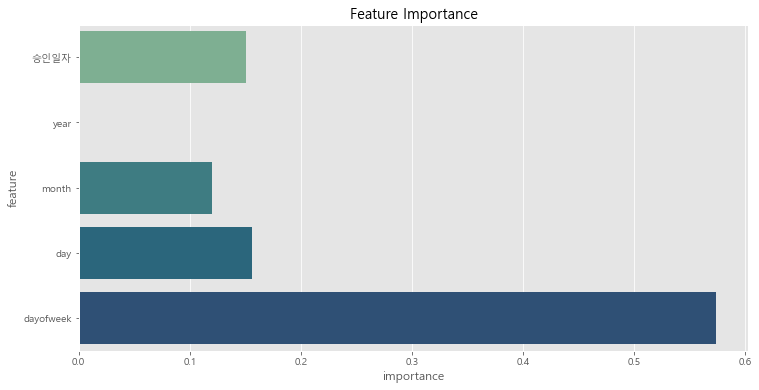

In [77]:
# %% 5-4. Model Interpretation
best_model = model_xgb

df_fi = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': best_model.feature_importances_
})

plt.figure(figsize=(12,6))

sns.barplot(data=df_fi, x='importance', y='feature', palette='crest')
plt.title('Feature Importance')
plt.show()
# %%

# 7. 결론

본 프로젝트에서는 RandomForest, XGBoost, LightGBM 세 가지 모델을 활용하여 2024년 6월의 신용카드 매출을 예측하였다. 평가 지표로 MSE 및 누적 오차를 활용하였다.

- XGBoost: 가장 낮은 MSE(4714.77)와 MAE(50.93)를 기록하며 가장 정확한 예측을 수행했다. 다만, 실제 매출 대비 약간 과소평가(-3.09%)되는 경향이 관찰되었다.
- RandomForest: 상대적으로 높은 MSE(8918.30)와 MAE(66.17)를 기록했다.
- LightGBM: MSE(7548.75), MAE(56.86)를 기록하며 XGBoost보다 높았으나 오차율(-1.80%)이 세 가지 모형 중 가장 낮았다.

LightGBM의 예측 오차는 약 460억(전체 매출의 1.8% 수준)으로, 높은 정확도로 미래 매출을 예측할 수 있다. 이를 기반으로 안정적인 매출 목표 설정과 예산 계획 수립이 가능하며 요일별 소비 패턴을 활용한 맞춤형 마케팅 전략을 통해 추가적인 매출 증대를 도모할 수 있다.

변동성이 크지 않은 신용카드 매출 데이터의 특성상 비교적 단순한 모형으로도 높은 정확도를 달성할 수 있었다. 급격한 변동이 있을 수 있는 업계에서는 보다 민감한 모형 구축이 필요하다.

공휴일 등 특정 요인의 매출 변동을 반영한 추가 모형 개선을 고려할 수도 있다. 2024년 6월 6일의 예측과 실제 실적 간 차이를 고려할 때 공휴일의 영향이 있었을 가능성이 크다.

# 8. References

In [53]:
import sklearn as sk
import xgboost as xgb
import lightgbm as lgb

print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'matplotlib version: {mpl.__version__}')
print(f'scikit-learn version: {sk.__version__}')
print(f'xgboost version: {xgb.__version__}')
print(f'lightgbm version: {lgb.__version__}')

numpy version: 1.19.2
pandas version: 1.1.5
seaborn version: 0.11.2
matplotlib version: 3.3.4
scikit-learn version: 0.24.2
xgboost version: 1.5.2
lightgbm version: 4.3.0
